#Unzip The datase into data

In [1]:
!pip install opencv-python-headless

  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (50.0 MB)


In [ ]:
%load_ext tensorboard

In [1]:
# import libraries
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import os
import json
import torch.nn as nn
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import math
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
from torchvision import models


#Utils and Helper Functions

In [2]:
N_KEYPOINTS = 21
N_IMG_CHANNELS = 3
RAW_IMG_SIZE = 224
MODEL_IMG_SIZE = 128
DATASET_MEANS = [0.3950, 0.4323, 0.2954]
DATASET_STDS = [0.1966, 0.1734, 0.1836]
MODEL_NEURONS = 16


COLORMAP = {
    "thumb": {"ids": [0, 1, 2, 3, 4], "color": "g"},
    "index": {"ids": [0, 5, 6, 7, 8], "color": "c"},
    "middle": {"ids": [0, 9, 10, 11, 12], "color": "b"},
    "ring": {"ids": [0, 13, 14, 15, 16], "color": "m"},
    "little": {"ids": [0, 17, 18, 19, 20], "color": "r"},
}


def project_points(xyz, K):
    """
    Projects 3D coordinates into image space.
    Function taken from https://github.com/lmb-freiburg/freihand
    """
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    return uv[:, :2] / uv[:, -1:]


def get_norm_params(dataloader):
    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    for i, sample in tqdm(enumerate(dataloader)):
        data = sample["image_raw"]
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return {"mean": mean, "std": std}


def vector_to_heatmaps(keypoints):
    HEATMAP_SIZE = MODEL_IMG_SIZE // 4
    
    heatmaps = np.zeros((N_KEYPOINTS, HEATMAP_SIZE, HEATMAP_SIZE), dtype=np.float32)
    
    for k, (x, y) in enumerate(keypoints):
        hx = int(x * HEATMAP_SIZE)
        hy = int(y * HEATMAP_SIZE)
        
        if 0 <= hx < HEATMAP_SIZE and 0 <= hy < HEATMAP_SIZE:
            heatmaps[k, hy, hx] = 1.0
    
    return blur_heatmaps(heatmaps)


def blur_heatmaps(heatmaps):
    heatmaps_blurred = heatmaps.copy()
    for k in range(len(heatmaps)):
        if heatmaps_blurred[k].max() == 1:
            heatmaps_blurred[k] = cv2.GaussianBlur(heatmaps[k], (39, 39), 3)
            heatmaps_blurred[k] = heatmaps_blurred[k] / heatmaps_blurred[k].max()
    return heatmaps_blurred


class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()
        self.EPSILON = 1e-6

    def _op_sum(self, x):
        return x.sum(-1).sum(-1)

    def forward(self, y_pred, y_true):
        inter = self._op_sum(y_true * y_pred)
        union = (
            self._op_sum(y_true ** 2)
            + self._op_sum(y_pred ** 2)
            - self._op_sum(y_true * y_pred)
        )
        iou = (inter + self.EPSILON) / (union + self.EPSILON)
        iou = torch.mean(iou)
        return 1 - iou


def heatmaps_to_coordinates(heatmaps):
    B, K, Hm, Wm = heatmaps.shape
    sums = heatmaps.sum(axis=(2,3), keepdims=True) + 1e-6
    norm = heatmaps / sums

    x_prob = norm.sum(axis=2)  
    y_prob = norm.sum(axis=3)  

    xs = np.arange(Wm, dtype=np.float32)
    ys = np.arange(Hm, dtype=np.float32)

    x_coords = (x_prob * xs[None,None,:]).sum(axis=2)  
    y_coords = (y_prob * ys[None,None,:]).sum(axis=2)  

    x_norm = x_coords / float(Wm)
    y_norm = y_coords / float(Hm)

    return np.stack([x_norm, y_norm], axis=-1)  



def show_data(dataset, n_samples=12):
    n_cols = 4
    n_rows = int(np.ceil(n_samples / n_cols))
    plt.figure(figsize=[15, n_rows * 4])

    ids = np.random.choice(dataset.__len__(), n_samples, replace=False)
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)

        image = sample["image_raw"].numpy()
        image = np.moveaxis(image, 0, -1)
        keypoints = sample["keypoints"].numpy()
        keypoints = keypoints * RAW_IMG_SIZE

        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
    plt.tight_layout()
    plt.show()


def show_batch_predictions(batch_data, model):
    inputs = batch_data["image"]
    true_keypoints = batch_data["keypoints"].detach().cpu().numpy()
    batch_size = true_keypoints.shape[0]
    pred_heatmaps= model(inputs)
    pred_heatmaps = pred_heatmaps.detach().cpu().numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)
    images = batch_data["image_raw"].numpy()
    images = np.moveaxis(images, 1, -1)

    plt.figure(figsize=[12, 4 * batch_size])
    for i in range(batch_size):
        image = images[i]
        true_keypoints_img = true_keypoints[i] * RAW_IMG_SIZE
        pred_keypoints_img = pred_keypoints[i] * RAW_IMG_SIZE

        plt.subplot(batch_size, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(batch_size, 3, i * 3 + 2)
        plt.imshow(image)
        for finger, params in COLORMAP.items():
            plt.plot(
                true_keypoints_img[params["ids"], 0],
                true_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("True Keypoints")
        plt.axis("off")

        plt.subplot(batch_size, 3, i * 3 + 3)
        plt.imshow(image)
        for finger, params in COLORMAP.items():
            plt.plot(
                pred_keypoints_img[params["ids"], 0],
                pred_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("Pred Keypoints")
        plt.axis("off")
    plt.tight_layout()

<h1>Custom Dataset</h1>

In [3]:
class FreiHAND(Dataset):
    def __init__(self, path, device="cuda", set_type="train"):        
        self.image_dir = os.path.join(path, "training/rgb")
        self.mask_dir = os.path.join(path, "training/mask")

        # Load all image filenames and the original coordinate sets
        image_names = np.sort(os.listdir(self.image_dir))

        mask_names = np.sort(os.listdir(self.mask_dir))

        with open(os.path.join(path, "training_K.json"), "r") as f:
            K_orig = np.array(json.load(f))
        with open(os.path.join(path, "training_xyz.json"), "r") as f:
            xyz_orig = np.array(json.load(f))

        # repeat coordinates and masks for duplicated images
        total_images = len(image_names)
        print("total images: ", total_images)
        orig_count = len(xyz_orig)
        repeats = total_images // orig_count

        if total_images % orig_count != 0:
            raise ValueError(
                f"Expected total images ({total_images}) to be a multiple of original coords ({orig_count})"
            )

        original_indices = np.arange(orig_count)
        train_end = int(0.70 * orig_count)
        val_end = train_end + int(0.15 * orig_count)

        if set_type == "train":
            split = original_indices[:train_end]
        elif set_type == "val":
            split = original_indices[train_end:val_end]
        else:
            split = original_indices[val_end:]

        #make offsets and select all variants
        offsets = original_indices * 0
        offsets = np.arange(repeats) * orig_count
        sel = (split[:,None] + offsets).ravel()

        self.image_names = image_names[sel]
        self.K_matrix = np.repeat(K_orig[split], repeats, axis=0)
        self.xyz = np.repeat(xyz_orig[split], repeats, axis=0)

        msel = np.repeat(split, repeats)
        self.mask_names = mask_names[msel]

        assert len(self.image_names) == len(self.K_matrix) == len(self.xyz)
        print(f"Split '{set_type}': {len(self.image_names)} images")
        
        self.image_raw_transform = transforms.ToTensor()
        self.image_transformations = transforms.Compose([
            transforms.Resize([MODEL_IMG_SIZE, MODEL_IMG_SIZE], Image.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS)
        ])
        self.mask_tf = transforms.Compose([
            transforms.Resize(MODEL_IMG_SIZE),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.xyz)

    def __getitem__(self, index):
        #load image
        img_name = self.image_names[index]
        img_path = os.path.join(self.image_dir, img_name)
        image_raw = Image.open(img_path).convert("RGB")
        image = self.image_transformations(image_raw)
        image_raw = self.image_raw_transform(image_raw)

        #load Mask
        mask_name = self.mask_names[index]
        mask_path = os.path.join(self.mask_dir, mask_name)
        mask_raw = Image.open(mask_path).convert("L")
        mask = self.mask_tf(mask_raw)

        #project and normalize keypoints
        keypoints = project_points(self.xyz[index], self.K_matrix[index])
        keypoints = keypoints / RAW_IMG_SIZE
        heatmaps = vector_to_heatmaps(keypoints)

        #convert to tensors
        keypoints = torch.from_numpy(keypoints).float()
        heatmaps = torch.from_numpy(np.float32(heatmaps))
        mask = mask.float()

        return {
            "image": image,
            "keypoints": keypoints,
            "heatmaps": heatmaps,
            "mask": mask,
            "image_name": img_name,
            "image_raw": image_raw
        }


# Model

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x, skip=None):
        x = self.upsample(x)
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class MobileNetV3LargeUNet(nn.Module):
    def __init__(self, num_keypoints=21, input_size=256):
        super().__init__()
        from torchvision.models import MobileNet_V3_Large_Weights
        mb = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
        features = mb.features

        #encoding layer
        self.enc1 = nn.Sequential(*features[:3])   
        self.enc2 = nn.Sequential(*features[3:6])  
        self.enc3 = nn.Sequential(*features[6:12]) 
        self.enc4 = nn.Sequential(*features[12:]) 

        # get channel sizes of mobile net features
        dummy = torch.zeros(1, 3, input_size, input_size)
        c1 = self.enc1(dummy).shape[1]
        c2 = self.enc2(self.enc1(dummy)).shape[1]
        c3 = self.enc3(self.enc2(self.enc1(dummy))).shape[1]
        _  = self.enc4(self.enc3(self.enc2(self.enc1(dummy))))

        #decoding layer
        self.dec1 = Decoder(in_channels=960 + c3, out_channels=256)
        self.dec2 = Decoder(in_channels=256 + c2, out_channels=128)
        self.dec3 = Decoder(in_channels=128 + c1, out_channels=64)

        self.head = nn.Sequential(
            nn.Conv2d(64, num_keypoints, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.enc1(x)  
        x2 = self.enc2(x1) 
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)

        d1 = self.dec1(x4, x3)  
        d2 = self.dec2(d1, x2)  
        d3 = self.dec3(d2, x1)  

        heatmaps = self.head(d3)
        return heatmaps


In [6]:
def calculate_accuracy(pred_heatmaps, true_heatmaps):
    pred_coords = heatmaps_to_coordinates(pred_heatmaps.detach().cpu().numpy())
    true_coords = heatmaps_to_coordinates(true_heatmaps.cpu().numpy())
    distances = np.sqrt(((pred_coords - true_coords)**2).sum(axis=2))
    correct = (distances < 0.05).sum()
    total = pred_coords.shape[0] * N_KEYPOINTS
    return correct / total

In [ ]:
dataset_path = '/Volumes/T7/Freihand/FreiHAND_pub_v2'

train_ds = FreiHAND(path=dataset_path, set_type="train")
val_ds = FreiHAND(path=dataset_path, set_type="val")
test_ds = FreiHAND(path=dataset_path, set_type="test")

train_loader = DataLoader(train_ds, batch_size=48, shuffle=True,  num_workers=4)
val_loader = DataLoader(val_ds,   batch_size=48, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds,  batch_size=48, shuffle=False, num_workers=4)


total images:  130240
Split 'train': 91168 images
total images:  130240
Split 'val': 19536 images
total images:  130240
Split 'test': 19536 images


In [8]:
model = MobileNetV3LargeUNet(21)

from torch import optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimiser = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(
    optimiser,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

criterion = nn.MSELoss()

model.to(device)

MobileNetV3LargeUNet(
  (enc1): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1

In [21]:
def save_model(model, optimizer, epoch, filename="model_11/checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, filename)
    print(f"✅ Saved model checkpoint to: {filename}")

In [ ]:
def train(model, optimiser, train_loader, val_loader, criterion, num_epochs, scheduler, patience=5, start_epoch=0):

    model = model.to(device)
    writer = SummaryWriter(log_dir="runs/experiment6_MobileNet")
    best_val_loss = math.inf
    epochs_no_improve = 0

    history = {
        'train_loss_total': [],
        'val_loss_total': []
    }

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss_total = 0.0
        total_samples = 0

        for index, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            images = batch["image"].to(device, non_blocking=True)
            true_heatmaps = batch["heatmaps"].to(device, non_blocking=True)

            optimiser.zero_grad()
            pred_heatmaps = model(images)
            loss = criterion(pred_heatmaps, true_heatmaps)

            loss.backward()
            optimiser.step()
            
            batch_size = images.size(0)
            running_loss_total += loss.item() * batch_size
            total_samples += batch_size
            
            if (index + 1) % 500 == 0:
                print(f"Batch {index+1}/{len(train_loader)} - Loss: {loss.item():.4f}")
            
        epoch_train_loss = running_loss_total / total_samples

        history['train_loss_total'].append(epoch_train_loss)
        writer.add_scalar("train/total_loss",   epoch_train_loss,  epoch+1)

        #Now calculate validation loss

        model.eval()
        val_loss_total = 0.0
        val_samples = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"[Epoch {epoch}] Validation"):
                images = batch["image"].to(device, non_blocking=True)
                true_heatmaps = batch["heatmaps"].to(device, non_blocking=True)

                pred_heatmaps = model(images)
                loss = criterion(pred_heatmaps, true_heatmaps)

                batch_size = images.size(0)
                val_loss_total += loss.item() * batch_size
                val_samples += batch_size

        epoch_val_loss = val_loss_total / val_samples

        history['val_loss_total'].append(epoch_val_loss)

        writer.add_scalar("val/total_loss",   epoch_val_loss,  epoch+1)

        scheduler.step(epoch_val_loss)
    
        print(f"Epoch {epoch+1} — "
            f"Train Loss Total: {epoch_train_loss:.4f} | "
            f"Val Loss Total: {epoch_val_loss:.4f} | "
        )

        #Only save if validation loss improves + implement early stopping
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            save_model(model, optimiser, epoch+1, f"model_12/checkpoint_{epoch+1}.pth")
            print(f"model saved (val_loss = {best_val_loss:.4f})")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s).")
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {patience} epochs with no improvement.")
                writer.close()
                break

    print(f"All {num_epochs} Epoch's finished - Training is complete")
    writer.close()
    return history


In [ ]:
history = train(model, optimiser, train_loader, val_loader, criterion, 100, scheduler)

Epoch 1:  26%|██▋       | 501/1900 [00:57<02:33,  9.10it/s]

Batch 500/1900 - Loss: 0.0056


Epoch 1:  53%|█████▎    | 1001/1900 [01:52<01:34,  9.49it/s]

Batch 1000/1900 - Loss: 0.0044


Epoch 1:  79%|███████▉  | 1501/1900 [02:49<00:44,  8.88it/s]

Batch 1500/1900 - Loss: 0.0034


[Epoch 0] Validation: 100%|██████████| 407/407 [00:41<00:00,  9.85it/s]


Epoch 1 — Train Loss Total: 0.0066 | Val Loss Total: 0.0041 | 
✅ Saved model checkpoint to: model_12/checkpoint_1.pth
model saved (val_loss = 0.0041)


Epoch 2:  26%|██▋       | 501/1900 [00:56<02:35,  9.00it/s]

Batch 500/1900 - Loss: 0.0030


Epoch 2:  53%|█████▎    | 1001/1900 [01:51<01:43,  8.65it/s]

Batch 1000/1900 - Loss: 0.0032


Epoch 2:  79%|███████▉  | 1501/1900 [02:47<00:45,  8.78it/s]

Batch 1500/1900 - Loss: 0.0030


[Epoch 1] Validation: 100%|██████████| 407/407 [00:41<00:00,  9.76it/s]


Epoch 2 — Train Loss Total: 0.0030 | Val Loss Total: 0.0035 | 
✅ Saved model checkpoint to: model_12/checkpoint_2.pth
model saved (val_loss = 0.0035)


Epoch 3:  26%|██▋       | 501/1900 [00:57<02:29,  9.33it/s]

Batch 500/1900 - Loss: 0.0028


Epoch 3:  53%|█████▎    | 1001/1900 [01:53<01:41,  8.90it/s]

Batch 1000/1900 - Loss: 0.0025


Epoch 3:  79%|███████▉  | 1501/1900 [02:49<00:43,  9.26it/s]

Batch 1500/1900 - Loss: 0.0022


[Epoch 2] Validation: 100%|██████████| 407/407 [00:41<00:00,  9.88it/s]


Epoch 3 — Train Loss Total: 0.0023 | Val Loss Total: 0.0031 | 
✅ Saved model checkpoint to: model_12/checkpoint_3.pth
model saved (val_loss = 0.0031)


Epoch 4:  26%|██▋       | 501/1900 [00:56<02:39,  8.75it/s]

Batch 500/1900 - Loss: 0.0023


Epoch 4:  53%|█████▎    | 1001/1900 [01:52<01:38,  9.12it/s]

Batch 1000/1900 - Loss: 0.0019


Epoch 4:  79%|███████▉  | 1501/1900 [02:48<00:43,  9.09it/s]

Batch 1500/1900 - Loss: 0.0023


[Epoch 3] Validation: 100%|██████████| 407/407 [00:41<00:00,  9.88it/s]


Epoch 4 — Train Loss Total: 0.0019 | Val Loss Total: 0.0029 | 
✅ Saved model checkpoint to: model_12/checkpoint_4.pth
model saved (val_loss = 0.0029)


Epoch 5:  26%|██▋       | 501/1900 [00:57<02:43,  8.54it/s]

Batch 500/1900 - Loss: 0.0015


Epoch 5:  53%|█████▎    | 1001/1900 [01:54<01:46,  8.44it/s]

Batch 1000/1900 - Loss: 0.0017


Epoch 5:  79%|███████▉  | 1501/1900 [02:50<00:44,  8.93it/s]

Batch 1500/1900 - Loss: 0.0014


[Epoch 4] Validation: 100%|██████████| 407/407 [00:41<00:00,  9.89it/s]


Epoch 5 — Train Loss Total: 0.0016 | Val Loss Total: 0.0029 | 
✅ Saved model checkpoint to: model_12/checkpoint_5.pth
model saved (val_loss = 0.0029)


Epoch 6:  26%|██▋       | 501/1900 [00:56<02:35,  8.99it/s]

Batch 500/1900 - Loss: 0.0014


Epoch 6:  53%|█████▎    | 1001/1900 [01:52<01:38,  9.10it/s]

Batch 1000/1900 - Loss: 0.0015


Epoch 6:  79%|███████▉  | 1501/1900 [02:48<00:44,  8.94it/s]

Batch 1500/1900 - Loss: 0.0015


[Epoch 5] Validation: 100%|██████████| 407/407 [00:40<00:00,  9.93it/s]


Epoch 6 — Train Loss Total: 0.0014 | Val Loss Total: 0.0025 | 
✅ Saved model checkpoint to: model_12/checkpoint_6.pth
model saved (val_loss = 0.0025)


Epoch 7:  26%|██▋       | 501/1900 [00:56<02:34,  9.05it/s]

Batch 500/1900 - Loss: 0.0012


Epoch 7:  53%|█████▎    | 1001/1900 [01:52<01:37,  9.21it/s]

Batch 1000/1900 - Loss: 0.0013


Epoch 7:  79%|███████▉  | 1501/1900 [02:47<00:42,  9.34it/s]

Batch 1500/1900 - Loss: 0.0014


[Epoch 6] Validation: 100%|██████████| 407/407 [00:41<00:00,  9.88it/s]


Epoch 7 — Train Loss Total: 0.0012 | Val Loss Total: 0.0028 | 
No improvement for 1 epoch(s).


Epoch 8:  26%|██▋       | 501/1900 [00:56<02:38,  8.83it/s]

Batch 500/1900 - Loss: 0.0010


Epoch 8:  53%|█████▎    | 1001/1900 [01:52<01:36,  9.32it/s]

Batch 1000/1900 - Loss: 0.0010


Epoch 8:  79%|███████▉  | 1501/1900 [02:49<00:46,  8.63it/s]

Batch 1500/1900 - Loss: 0.0010


[Epoch 7] Validation: 100%|██████████| 407/407 [00:41<00:00,  9.86it/s]


Epoch 8 — Train Loss Total: 0.0011 | Val Loss Total: 0.0025 | 
✅ Saved model checkpoint to: model_12/checkpoint_8.pth
model saved (val_loss = 0.0025)


Epoch 9:  26%|██▋       | 501/1900 [00:56<02:31,  9.22it/s]

Batch 500/1900 - Loss: 0.0008


Epoch 9:  53%|█████▎    | 1001/1900 [01:52<01:38,  9.17it/s]

Batch 1000/1900 - Loss: 0.0009


Epoch 9:  79%|███████▉  | 1501/1900 [02:48<00:45,  8.73it/s]

Batch 1500/1900 - Loss: 0.0009


[Epoch 8] Validation: 100%|██████████| 407/407 [00:40<00:00, 10.06it/s]


Epoch 9 — Train Loss Total: 0.0010 | Val Loss Total: 0.0025 | 
✅ Saved model checkpoint to: model_12/checkpoint_9.pth
model saved (val_loss = 0.0025)


Epoch 10:  26%|██▋       | 501/1900 [00:56<02:29,  9.34it/s]

Batch 500/1900 - Loss: 0.0009


Epoch 10:  53%|█████▎    | 1001/1900 [01:52<01:43,  8.71it/s]

Batch 1000/1900 - Loss: 0.0009


Epoch 10:  79%|███████▉  | 1501/1900 [02:47<00:43,  9.09it/s]

Batch 1500/1900 - Loss: 0.0008


[Epoch 9] Validation: 100%|██████████| 407/407 [00:41<00:00,  9.82it/s]


Epoch 10 — Train Loss Total: 0.0009 | Val Loss Total: 0.0025 | 
✅ Saved model checkpoint to: model_12/checkpoint_10.pth
model saved (val_loss = 0.0025)


Epoch 11:  26%|██▋       | 501/1900 [00:56<02:34,  9.07it/s]

Batch 500/1900 - Loss: 0.0009


Epoch 11:  53%|█████▎    | 1001/1900 [01:52<01:51,  8.03it/s]

Batch 1000/1900 - Loss: 0.0008


Epoch 11:  79%|███████▉  | 1501/1900 [02:48<00:43,  9.24it/s]

Batch 1500/1900 - Loss: 0.0008


[Epoch 10] Validation: 100%|██████████| 407/407 [00:40<00:00,  9.99it/s]


Epoch 11 — Train Loss Total: 0.0008 | Val Loss Total: 0.0024 | 
✅ Saved model checkpoint to: model_12/checkpoint_11.pth
model saved (val_loss = 0.0024)


Epoch 12:  26%|██▋       | 501/1900 [00:56<02:30,  9.30it/s]

Batch 500/1900 - Loss: 0.0008


Epoch 12:  53%|█████▎    | 1001/1900 [01:51<01:34,  9.50it/s]

Batch 1000/1900 - Loss: 0.0008


Epoch 12:  79%|███████▉  | 1501/1900 [02:47<00:43,  9.23it/s]

Batch 1500/1900 - Loss: 0.0007


[Epoch 11] Validation: 100%|██████████| 407/407 [00:40<00:00, 10.05it/s]


Epoch 12 — Train Loss Total: 0.0007 | Val Loss Total: 0.0025 | 
No improvement for 1 epoch(s).


Epoch 13:  26%|██▋       | 501/1900 [00:56<02:37,  8.86it/s]

Batch 500/1900 - Loss: 0.0009


Epoch 13:  53%|█████▎    | 1001/1900 [01:51<01:42,  8.80it/s]

Batch 1000/1900 - Loss: 0.0007


Epoch 13:  79%|███████▉  | 1501/1900 [02:47<00:43,  9.19it/s]

Batch 1500/1900 - Loss: 0.0007


[Epoch 12] Validation: 100%|██████████| 407/407 [00:40<00:00,  9.94it/s]


Epoch 13 — Train Loss Total: 0.0008 | Val Loss Total: 0.0024 | 
✅ Saved model checkpoint to: model_12/checkpoint_13.pth
model saved (val_loss = 0.0024)


Epoch 14:  26%|██▋       | 501/1900 [00:56<02:37,  8.88it/s]

Batch 500/1900 - Loss: 0.0006


Epoch 14:  53%|█████▎    | 1001/1900 [01:51<01:41,  8.82it/s]

Batch 1000/1900 - Loss: 0.0007


Epoch 14:  79%|███████▉  | 1501/1900 [02:47<00:46,  8.56it/s]

Batch 1500/1900 - Loss: 0.0006


[Epoch 13] Validation: 100%|██████████| 407/407 [00:40<00:00, 10.01it/s]


Epoch 14 — Train Loss Total: 0.0006 | Val Loss Total: 0.0024 | 
No improvement for 1 epoch(s).


Epoch 15:  26%|██▋       | 501/1900 [00:56<02:33,  9.13it/s]

Batch 500/1900 - Loss: 0.0006


Epoch 15:  53%|█████▎    | 1001/1900 [01:51<01:41,  8.86it/s]

Batch 1000/1900 - Loss: 0.0006


Epoch 15:  79%|███████▉  | 1501/1900 [02:46<00:43,  9.10it/s]

Batch 1500/1900 - Loss: 0.0006


[Epoch 14] Validation: 100%|██████████| 407/407 [00:40<00:00,  9.96it/s]


Epoch 15 — Train Loss Total: 0.0006 | Val Loss Total: 0.0028 | 
No improvement for 2 epoch(s).


Epoch 16:  26%|██▋       | 501/1900 [00:56<02:35,  8.98it/s]

Batch 500/1900 - Loss: 0.0006


Epoch 16:  53%|█████▎    | 1001/1900 [01:51<01:35,  9.37it/s]

Batch 1000/1900 - Loss: 0.0006


Epoch 16:  79%|███████▉  | 1501/1900 [02:46<00:42,  9.34it/s]

Batch 1500/1900 - Loss: 0.0005


[Epoch 15] Validation: 100%|██████████| 407/407 [00:40<00:00, 10.03it/s]


Epoch 16 — Train Loss Total: 0.0006 | Val Loss Total: 0.0024 | 
✅ Saved model checkpoint to: model_12/checkpoint_16.pth
model saved (val_loss = 0.0024)


Epoch 17:  26%|██▋       | 501/1900 [00:56<02:35,  9.00it/s]

Batch 500/1900 - Loss: 0.0005


Epoch 17:  53%|█████▎    | 1001/1900 [01:51<01:36,  9.27it/s]

Batch 1000/1900 - Loss: 0.0006


Epoch 17:  79%|███████▉  | 1501/1900 [02:47<00:43,  9.23it/s]

Batch 1500/1900 - Loss: 0.0006


[Epoch 16] Validation: 100%|██████████| 407/407 [00:40<00:00,  9.96it/s]


Epoch 17 — Train Loss Total: 0.0006 | Val Loss Total: 0.0024 | 
✅ Saved model checkpoint to: model_12/checkpoint_17.pth
model saved (val_loss = 0.0024)


Epoch 18:  26%|██▋       | 501/1900 [00:56<02:39,  8.75it/s]

Batch 500/1900 - Loss: 0.0005


Epoch 18:  53%|█████▎    | 1001/1900 [01:52<01:39,  9.03it/s]

Batch 1000/1900 - Loss: 0.0005


Epoch 18:  79%|███████▉  | 1501/1900 [02:47<00:43,  9.09it/s]

Batch 1500/1900 - Loss: 0.0005


[Epoch 17] Validation: 100%|██████████| 407/407 [00:40<00:00,  9.99it/s]


Epoch 18 — Train Loss Total: 0.0005 | Val Loss Total: 0.0024 | 
No improvement for 1 epoch(s).


Epoch 19:  26%|██▋       | 501/1900 [00:55<02:29,  9.36it/s]

Batch 500/1900 - Loss: 0.0005


Epoch 19:  53%|█████▎    | 1001/1900 [01:50<01:35,  9.39it/s]

Batch 1000/1900 - Loss: 0.0005


Epoch 19:  79%|███████▉  | 1501/1900 [02:45<00:42,  9.40it/s]

Batch 1500/1900 - Loss: 0.0005


[Epoch 18] Validation: 100%|██████████| 407/407 [00:40<00:00, 10.02it/s]


Epoch 19 — Train Loss Total: 0.0005 | Val Loss Total: 0.0024 | 
No improvement for 2 epoch(s).


Epoch 20:  26%|██▋       | 501/1900 [00:56<02:33,  9.13it/s]

Batch 500/1900 - Loss: 0.0005


Epoch 20:  53%|█████▎    | 1001/1900 [01:51<01:41,  8.89it/s]

Batch 1000/1900 - Loss: 0.0005


Epoch 20:  79%|███████▉  | 1501/1900 [02:47<00:42,  9.35it/s]

Batch 1500/1900 - Loss: 0.0005


[Epoch 19] Validation: 100%|██████████| 407/407 [00:40<00:00, 10.05it/s]


Epoch 20 — Train Loss Total: 0.0005 | Val Loss Total: 0.0023 | 
✅ Saved model checkpoint to: model_12/checkpoint_20.pth
model saved (val_loss = 0.0023)


Epoch 21:  26%|██▋       | 501/1900 [00:56<02:33,  9.13it/s]

Batch 500/1900 - Loss: 0.0004


Epoch 21:  53%|█████▎    | 1001/1900 [01:51<01:38,  9.08it/s]

Batch 1000/1900 - Loss: 0.0005


Epoch 21:  79%|███████▉  | 1501/1900 [02:46<00:42,  9.34it/s]

Batch 1500/1900 - Loss: 0.0005


[Epoch 20] Validation: 100%|██████████| 407/407 [00:40<00:00, 10.00it/s]


Epoch 21 — Train Loss Total: 0.0005 | Val Loss Total: 0.0024 | 
No improvement for 1 epoch(s).


Epoch 22:  26%|██▋       | 501/1900 [00:56<02:35,  8.99it/s]

Batch 500/1900 - Loss: 0.0005


Epoch 22:  53%|█████▎    | 1001/1900 [01:50<01:35,  9.40it/s]

Batch 1000/1900 - Loss: 0.0004


Epoch 22:  79%|███████▉  | 1501/1900 [02:45<00:45,  8.74it/s]

Batch 1500/1900 - Loss: 0.0005


[Epoch 21] Validation: 100%|██████████| 407/407 [00:40<00:00, 10.07it/s]


Epoch 22 — Train Loss Total: 0.0005 | Val Loss Total: 0.0023 | 
✅ Saved model checkpoint to: model_12/checkpoint_22.pth
model saved (val_loss = 0.0023)


Epoch 23:  26%|██▋       | 501/1900 [00:56<02:38,  8.85it/s]

Batch 500/1900 - Loss: 0.0004


Epoch 23:  53%|█████▎    | 1001/1900 [01:51<01:40,  8.97it/s]

Batch 1000/1900 - Loss: 0.0004


Epoch 23:  79%|███████▉  | 1501/1900 [02:47<00:43,  9.15it/s]

Batch 1500/1900 - Loss: 0.0005


[Epoch 22] Validation: 100%|██████████| 407/407 [00:41<00:00,  9.90it/s]


Epoch 23 — Train Loss Total: 0.0004 | Val Loss Total: 0.0023 | 
No improvement for 1 epoch(s).


Epoch 24:  26%|██▋       | 501/1900 [00:56<02:38,  8.82it/s]

Batch 500/1900 - Loss: 0.0004


Epoch 24:  53%|█████▎    | 1001/1900 [01:51<01:38,  9.13it/s]

Batch 1000/1900 - Loss: 0.0004


Epoch 24:  79%|███████▉  | 1501/1900 [02:47<00:43,  9.22it/s]

Batch 1500/1900 - Loss: 0.0004


[Epoch 23] Validation: 100%|██████████| 407/407 [00:40<00:00, 10.04it/s]


Epoch 24 — Train Loss Total: 0.0004 | Val Loss Total: 0.0023 | 
No improvement for 2 epoch(s).


Epoch 25:  26%|██▋       | 500/1900 [00:56<02:42,  8.64it/s]

Batch 500/1900 - Loss: 0.0004


Epoch 25:  53%|█████▎    | 1001/1900 [01:52<01:39,  9.02it/s]

Batch 1000/1900 - Loss: 0.0004


Epoch 25:  79%|███████▉  | 1501/1900 [02:47<00:46,  8.61it/s]

Batch 1500/1900 - Loss: 0.0004


[Epoch 24] Validation: 100%|██████████| 407/407 [00:41<00:00,  9.91it/s]


Epoch 25 — Train Loss Total: 0.0004 | Val Loss Total: 0.0023 | 
No improvement for 3 epoch(s).


Epoch 26:  26%|██▋       | 501/1900 [00:56<02:36,  8.92it/s]

Batch 500/1900 - Loss: 0.0004


Epoch 26:  53%|█████▎    | 1001/1900 [01:51<01:41,  8.87it/s]

Batch 1000/1900 - Loss: 0.0004


Epoch 26:  79%|███████▉  | 1501/1900 [02:47<00:44,  8.91it/s]

Batch 1500/1900 - Loss: 0.0004


[Epoch 25] Validation: 100%|██████████| 407/407 [00:40<00:00,  9.98it/s]


Epoch 26 — Train Loss Total: 0.0004 | Val Loss Total: 0.0023 | 
✅ Saved model checkpoint to: model_12/checkpoint_26.pth
model saved (val_loss = 0.0023)


Epoch 27:  26%|██▋       | 501/1900 [00:56<02:34,  9.03it/s]

Batch 500/1900 - Loss: 0.0003


Epoch 27:  53%|█████▎    | 1001/1900 [01:52<01:39,  8.99it/s]

Batch 1000/1900 - Loss: 0.0003


Epoch 27:  79%|███████▉  | 1501/1900 [02:47<00:46,  8.64it/s]

Batch 1500/1900 - Loss: 0.0003


[Epoch 26] Validation: 100%|██████████| 407/407 [00:40<00:00, 10.12it/s]


Epoch 27 — Train Loss Total: 0.0003 | Val Loss Total: 0.0023 | 
✅ Saved model checkpoint to: model_12/checkpoint_27.pth
model saved (val_loss = 0.0023)


Epoch 28:  26%|██▋       | 501/1900 [00:56<02:34,  9.07it/s]

Batch 500/1900 - Loss: 0.0003


Epoch 28:  53%|█████▎    | 1001/1900 [01:51<01:38,  9.16it/s]

Batch 1000/1900 - Loss: 0.0003


Epoch 28:  79%|███████▉  | 1501/1900 [02:46<00:43,  9.09it/s]

Batch 1500/1900 - Loss: 0.0003


[Epoch 27] Validation: 100%|██████████| 407/407 [00:40<00:00, 10.02it/s]


Epoch 28 — Train Loss Total: 0.0003 | Val Loss Total: 0.0023 | 
No improvement for 1 epoch(s).


Epoch 29:  26%|██▋       | 501/1900 [00:55<02:28,  9.39it/s]

Batch 500/1900 - Loss: 0.0003


Epoch 29:  53%|█████▎    | 1001/1900 [01:51<01:37,  9.23it/s]

Batch 1000/1900 - Loss: 0.0003


Epoch 29:  79%|███████▉  | 1501/1900 [02:46<00:43,  9.13it/s]

Batch 1500/1900 - Loss: 0.0003


[Epoch 28] Validation: 100%|██████████| 407/407 [00:40<00:00,  9.93it/s]


Epoch 29 — Train Loss Total: 0.0003 | Val Loss Total: 0.0023 | 
No improvement for 2 epoch(s).


Epoch 30:  26%|██▋       | 501/1900 [00:56<02:41,  8.66it/s]

Batch 500/1900 - Loss: 0.0003


Epoch 30:  53%|█████▎    | 1001/1900 [01:51<01:39,  9.02it/s]

Batch 1000/1900 - Loss: 0.0003


Epoch 30:  79%|███████▉  | 1501/1900 [02:47<00:42,  9.42it/s]

Batch 1500/1900 - Loss: 0.0003


[Epoch 29] Validation: 100%|██████████| 407/407 [00:40<00:00, 10.02it/s]


Epoch 30 — Train Loss Total: 0.0003 | Val Loss Total: 0.0023 | 
No improvement for 3 epoch(s).


Epoch 31:  26%|██▋       | 501/1900 [00:56<02:34,  9.03it/s]

Batch 500/1900 - Loss: 0.0003


Epoch 31:  53%|█████▎    | 1001/1900 [01:51<01:38,  9.09it/s]

Batch 1000/1900 - Loss: 0.0003


Epoch 31:  79%|███████▉  | 1501/1900 [02:46<00:43,  9.18it/s]

Batch 1500/1900 - Loss: 0.0003


[Epoch 30] Validation: 100%|██████████| 407/407 [00:40<00:00,  9.96it/s]


Epoch 31 — Train Loss Total: 0.0003 | Val Loss Total: 0.0023 | 
No improvement for 4 epoch(s).


Epoch 32:  26%|██▋       | 501/1900 [00:56<02:35,  8.99it/s]

Batch 500/1900 - Loss: 0.0003


Epoch 32:  53%|█████▎    | 1001/1900 [01:51<01:45,  8.48it/s]

Batch 1000/1900 - Loss: 0.0002


Epoch 32:  79%|███████▉  | 1501/1900 [02:46<00:45,  8.86it/s]

Batch 1500/1900 - Loss: 0.0003


[Epoch 31] Validation: 100%|██████████| 407/407 [00:40<00:00, 10.02it/s]

Epoch 32 — Train Loss Total: 0.0002 | Val Loss Total: 0.0023 | 
No improvement for 5 epoch(s).
Early stopping triggered after 5 epochs with no improvement.
All 100 Epoch's finished - Training is complete


In [ ]:
%tensorboard --logdir runs/experiment1 --port 6006

In [9]:
def load_model(path, model, optimizer, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    last_epoch = checkpoint["epoch"]

    model.to(device)

In [10]:
load_model("checkpoint_11_128.pth", model, optimiser, device)

In [ ]:
def keypoint_error(true_kpts, pred_kpts):
    d2 = (true_kpts - pred_kpts)**2               
    dist = np.sqrt(d2.sum(axis=2))                
    return dist.mean(axis=1)                      

In [ ]:
model.eval()
model = model.to(device)

accuracy_all = []

for data in tqdm(test_loader):
    inputs = data["image"].to(device)
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.detach().cpu().numpy()
    true_keypoints = data["keypoints"].detach().cpu().numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    accuracy_image = keypoint_error(true_kpts=true_keypoints, pred_kpts=pred_keypoints)
    accuracy_all.extend(list(accuracy_image))

100%|██████████| 407/407 [00:46<00:00,  8.73it/s]


In [16]:
error = np.mean(accuracy_all)
print("Average Error per keypoint: {:.1f}% from image size".format(error*100))

for img_size in [MODEL_IMG_SIZE, RAW_IMG_SIZE]:
    error_pixels = error * img_size
    image_size = f"{img_size}X{img_size}"
    print(
        "Average error per keypoint: {:.0f} pixels for image {}".format(
                error_pixels, image_size
        )
    )

Average Error per keypoint: 3.7% from image size
Average error per keypoint: 5 pixels for image 128X128
Average error per keypoint: 8 pixels for image 224X224


In [13]:
model.to(device)
# dataset_path = 'data'
batch_test_dataset = FreiHAND(dataset_path, set_type="val")
batch_test_loader = DataLoader(batch_test_dataset, shuffle=True, batch_size=8, drop_last=True, num_workers=0)

total images:  130240
Split 'val': 19536 images


total images:  130240
Split 'val': 19536 images


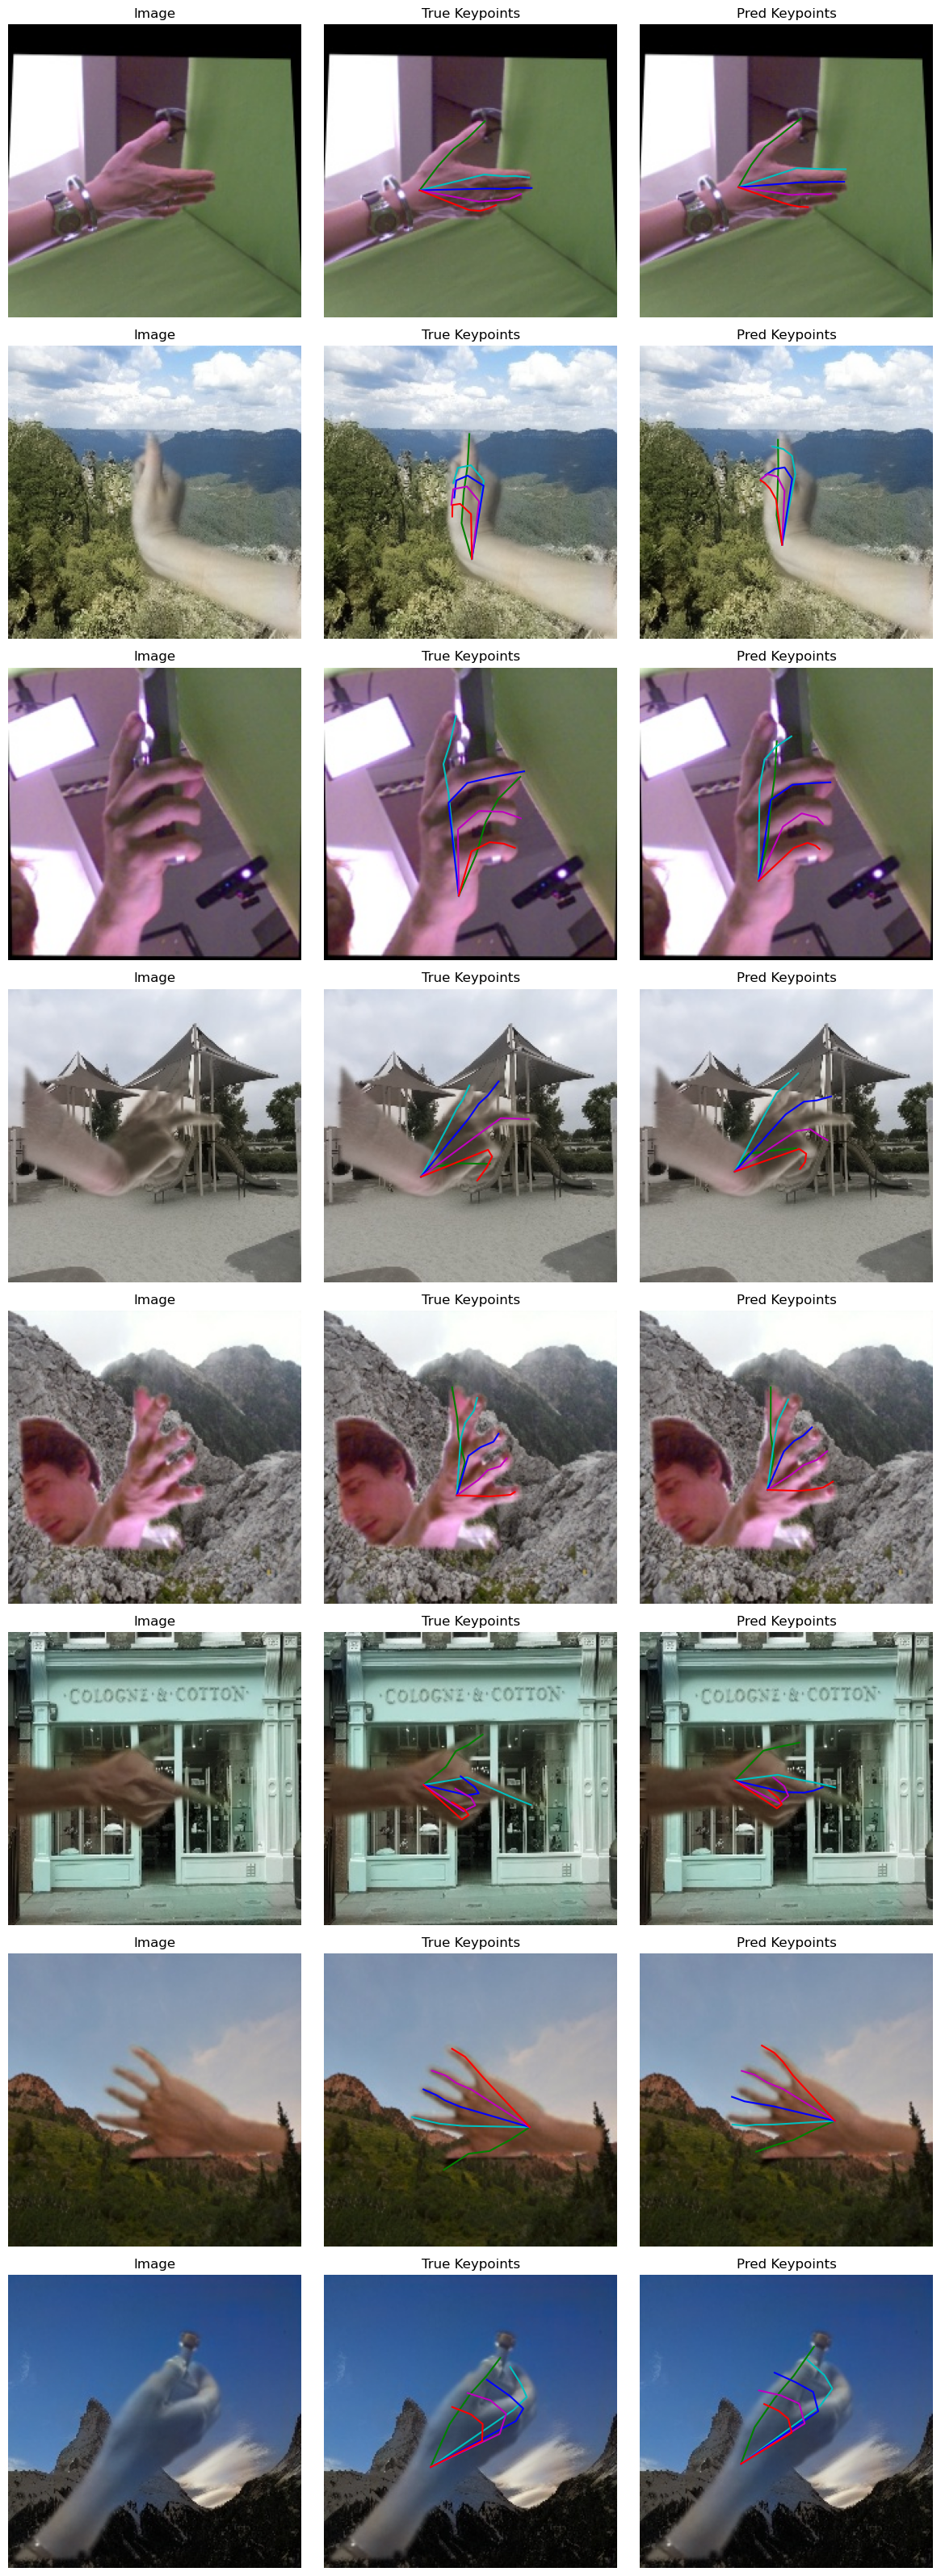

In [ ]:
for data in batch_test_loader:
    images = data["image"].to(device, non_blocking=True)
    keypoints = data["keypoints"].to(device, non_blocking=True).cpu()
    heatmaps = data["heatmaps"].to(device, non_blocking=True).cpu()
    image_raw = data["image_raw"]
    show_batch_predictions(
        {"image": images, "keypoints": keypoints, "heatmaps": heatmaps, "image_raw": image_raw},
        model
    )
    break

In [11]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms


def debug_show_crop_stages(orig_img, cropped_img, resized_img):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 4)
    plt.hist(np.array(orig_img).ravel(), bins=50, range=(0, 255))
    plt.title("Original Image Histogram")
    
    plt.subplot(2, 3, 6)
    plt.hist(np.array(resized_img).ravel(), bins=50, range=(0, 255))
    plt.title("Resized Image Histogram")
    
    plt.tight_layout()
    plt.show()

def debug_tensor_stats(tensor, stage_name=None):
    print(f"\n===== {stage_name} =====")
    print(f"Shape: {tensor.shape}")
    
    if tensor.shape[0] == 3:  
        means = tensor.mean(dim=[1,2]).numpy()
        stds = tensor.std(dim=[1,2]).numpy()
        print(f"Channel means: {np.round(means, 3)}")
        print(f"Channel stds: {np.round(stds, 3)}")

def center_crop_square(img: Image.Image):
    w, h = img.size
    side = min(w, h)
    left = (w - side) // 2
    top = (h - side) // 2
    
    print(f"\nCenter Crop Parameters:")
    print(f"Original size: ({w}, {h})")
    print(f"Crop size: {side}x{side}")
    print(f"Crop coordinates: left={left}, top={top}")
    
    return img.crop((left, top, left+side, top+side)), side, left, top

def test_and_plot_image(image_path, model, device="cpu", train_sample=None):
    orig_img = Image.open(image_path).convert("RGB")
    print(f"\n=== Processing {image_path} ===")
    print(f"Original size: {orig_img.size}")

    square, side, left, top = center_crop_square(orig_img)
    
    print(f"\nResizing to: {MODEL_IMG_SIZE}x{MODEL_IMG_SIZE}")
    square128 = square.resize((MODEL_IMG_SIZE, MODEL_IMG_SIZE), Image.BILINEAR)

    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(DATASET_MEANS, DATASET_STDS),
    ])
    
    raw_tensor = transforms.ToTensor()(square128)
    debug_tensor_stats(raw_tensor, "Before Normalization")
    
    x = preprocess(square128).unsqueeze(0).to(device)
    plot_distribution_comparison(train_sample, x.squeeze(0).cpu())

    debug_tensor_stats(x.squeeze(0).cpu(), "After Normalization")

    print("\nRunning inference...")
    model.eval()
    with torch.no_grad():
        heatmaps = model(x)
    
    print(f"Heatmap shape: {heatmaps.shape}")

    heatmaps_np = heatmaps.squeeze(0).cpu().numpy()
    keypoints_norm = heatmaps_to_coordinates(heatmaps_np[None, ...])[0]
    
    coords_square128 = keypoints_norm * MODEL_IMG_SIZE
    plt.figure(figsize=(6,6))
    plt.imshow(square128)
    for finger, params in COLORMAP.items():
        ids = params["ids"]
        color = params["color"]
        pts = coords_square128[ids]
        plt.plot(pts[:,0], pts[:,1], '-', linewidth=2, alpha=0.8, color=color)
        plt.scatter(pts[:,0], pts[:,1], s=30, color=color)
    for idx, (x_coord, y_coord) in enumerate(coords_square128):
        plt.text(x_coord+2, y_coord+2, str(idx), color="white", fontsize=8)
    plt.title("Cropped & Resized Input with Predicted Keypoints")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    coords_orig = (keypoints_norm * side) + np.array([left, top])
    plt.figure(figsize=(6,6))
    plt.imshow(orig_img)
    for finger, params in COLORMAP.items():
        ids = params["ids"]
        color = params["color"]
        pts = coords_orig[ids]
        plt.plot(pts[:,0], pts[:,1], '-', linewidth=2, alpha=0.8, color=color)
        plt.scatter(pts[:,0], pts[:,1], s=30, color=color)
    for idx, (x_coord, y_coord) in enumerate(coords_orig):
        plt.text(x_coord+2, y_coord+2, str(idx), color="white", fontsize=8)
    plt.title("Original Image with Predicted Keypoints")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(heatmaps_np[0], cmap='hot')
    plt.title("First Keypoint Heatmap")
    plt.subplot(122)
    plt.imshow(np.max(heatmaps_np, axis=0), cmap='hot')
    plt.title("Max Across All Heatmaps")
    plt.show()

def plot_distribution_comparison(train_tensor, test_tensor):
    plt.figure(figsize=(10, 6))
    
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.hist(train_tensor[i].ravel(), bins=50, alpha=0.5, label='Train')
        plt.hist(test_tensor[i].ravel(), bins=50, alpha=0.5, label='Test')
        plt.title(f'Channel {i} Distribution Comparison')
        plt.legend()
    
    plt.tight_layout()
    plt.show()


Using device: cpu

=== Processing test_images/val/Photo on 28-4-2025 at 11.56 am #3.jpg ===
Original size: (1228, 818)

Center Crop Parameters:
Original size: (1228, 818)
Crop size: 818x818
Crop coordinates: left=205, top=0

Resizing to: 128x128

===== Before Normalization =====
Shape: torch.Size([3, 128, 128])
Channel means: [0.581 0.519 0.463]
Channel stds: [0.202 0.189 0.165]


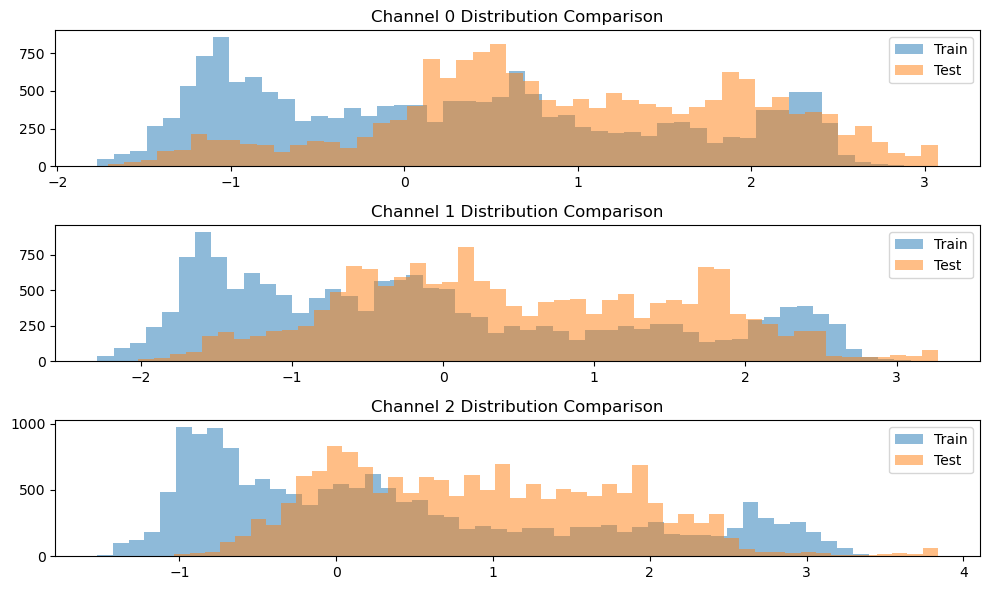


===== After Normalization =====
Shape: torch.Size([3, 128, 128])
Channel means: [0.947 0.502 0.911]
Channel stds: [1.028 1.091 0.897]

Running inference...
Heatmap shape: torch.Size([1, 21, 32, 32])


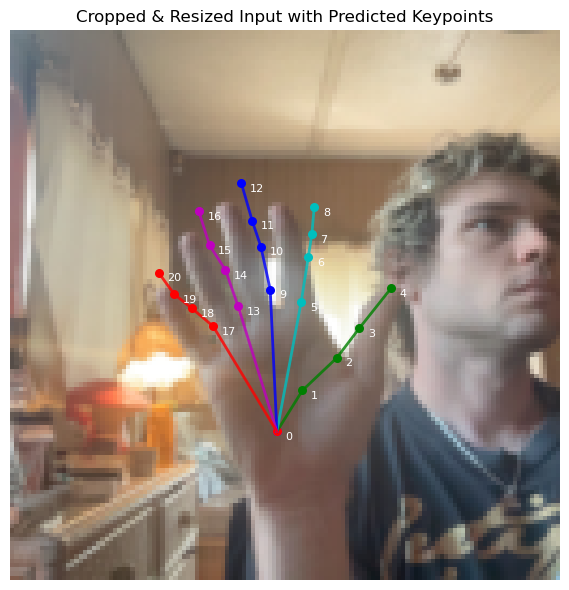

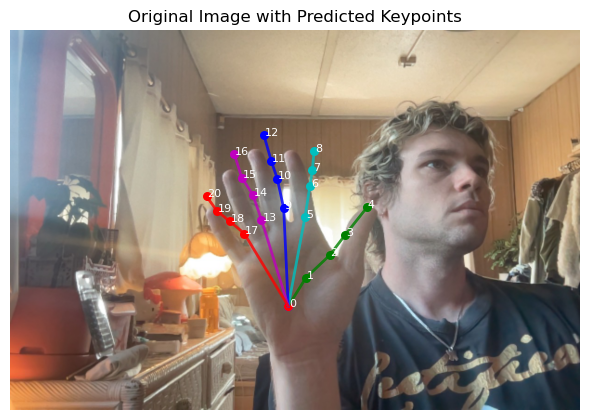

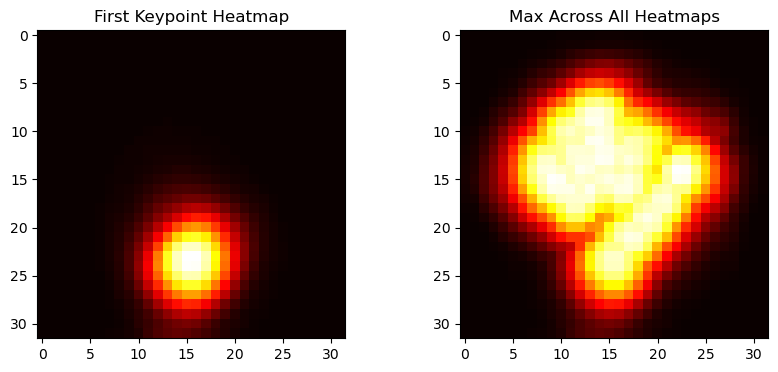

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

batch_test_loader = DataLoader(batch_test_dataset, shuffle=True, batch_size=8, drop_last=True, num_workers=0)

train_sample = next(iter(batch_test_loader))['image'][0]  


# Test image
# test_image_path = "data/evaluation/rgb/00000004.jpg"
test_image_path = "test_images/val/Photo on 28-4-2025 at 11.56 am #3.jpg"
test_and_plot_image(test_image_path, model, device, train_sample)
